# Zillow Project
## Home Value Prediction
### Methodology: Regression



### Project Goals

- Identify key drivers of value for single family properties.
- Build a Machine Learning Regression model that effectively predicts property tax assessed values using the identified drivers.
- Review findings and provide recommendations for future improvements of the model's performance.

In [1]:
# Library imports used for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings("ignore")

# Modules created for this report
import wrangle as w
import explore as e
import model as m

from env import user, host, password

## Acquire

- Data acquired from the Codeup mySQL server
- It contained 52,441 rows and 6 columns
- Each observation represents a single-family home
- Each column represents a feature of those homes

In [2]:
# import raw data from Codeup mySQL server
zillow_raw = w.acquire_zillow_data()

## Prepare

Dropped rows:

- Duplicates
- Rows where bedrooms == 0 AND bathrooms == 0
- Rows where square_feet >= 10,000 (because these are large and can skew the data)
- Rows where home_value >= 1,600,000 (because these values are large and can skew the data)
- Rows containing null values in any column 

Engineered features:

- county (names based on the fips code):
- 6037: LA
- 6059: Orange
- 6111: Ventura
- bath_bed_ratio
- Column displaying bathrooms/bedrooms
- 2017_age
- Column diplaying age of house as of 2017 (2017-year_built)

Split data into train, validate, and tests 
- 65/20/15

In [3]:
# clean data
zillow = w.clean_zillow(zillow_raw)

In [4]:
# split data
train, validate, test = w.split_data(zillow)

### Preview of the Data (cleaned)

In [5]:
# first 5 of the train data
train.head()

,parcelid,bathrooms,bedrooms,home_value,square_feet,year_built,bath_bed_ratio,county,2017_age
43055,13955676,2.5,3,467000.0,1509,2001,0.833333,Orange,16
27580,14184733,3.0,5,411581.0,2822,1993,0.600000,Orange,24
38642,10889898,1.0,2,156917.0,878,1940,0.500000,LA,77
40986,12579090,2.0,4,264953.0,1620,1964,0.500000,LA,53
37881,12919161,2.0,4,402200.0,1128,1955,0.500000,LA,62


## Explore

### *Is there a strong relationship with home value and location?*

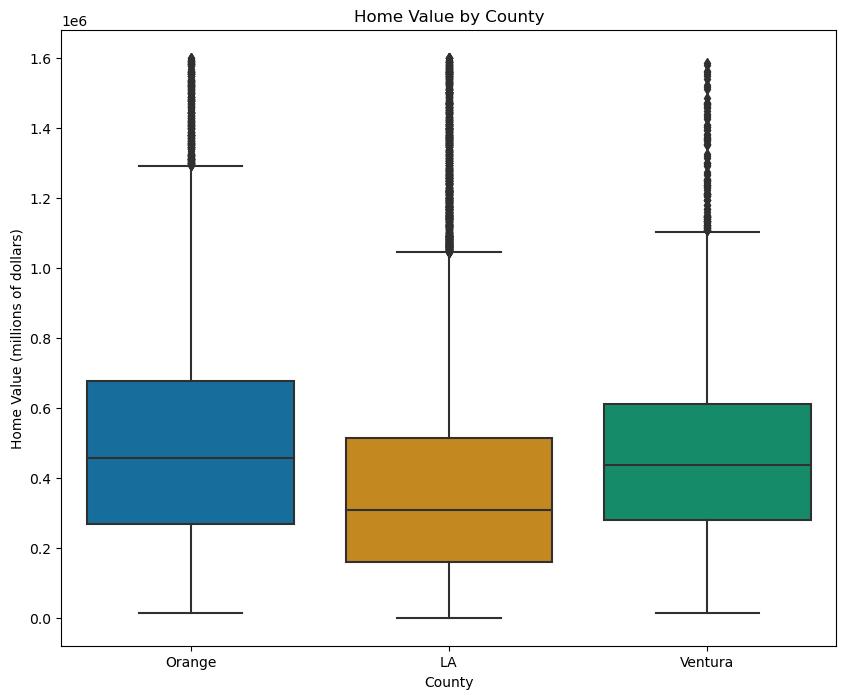

In [6]:
# visual for home values by county/fips/location
e.county_viz(train)

**It looks like there is a difference in home values in each county**

**Set Hypothesis**

**H$_0$** = The average home values of those in LA county, Orange county, and Ventura county are not significantly different from each other.

**H$_a$** = The average home values of those in LA county, Orange county, and Ventura county are significantly different from each other.

In [7]:
# ANOVA test and results
e.county_ANOVA(train)

F-score: 495.59484
p-value: 9.732e-213


**Since p < alpha, we can reject the null hypothesis and say that average home values of those in LA county, Orange county and Ventura county are significantly different from eachother**

### *Is there a significant relationship between age of the home and home value?* 

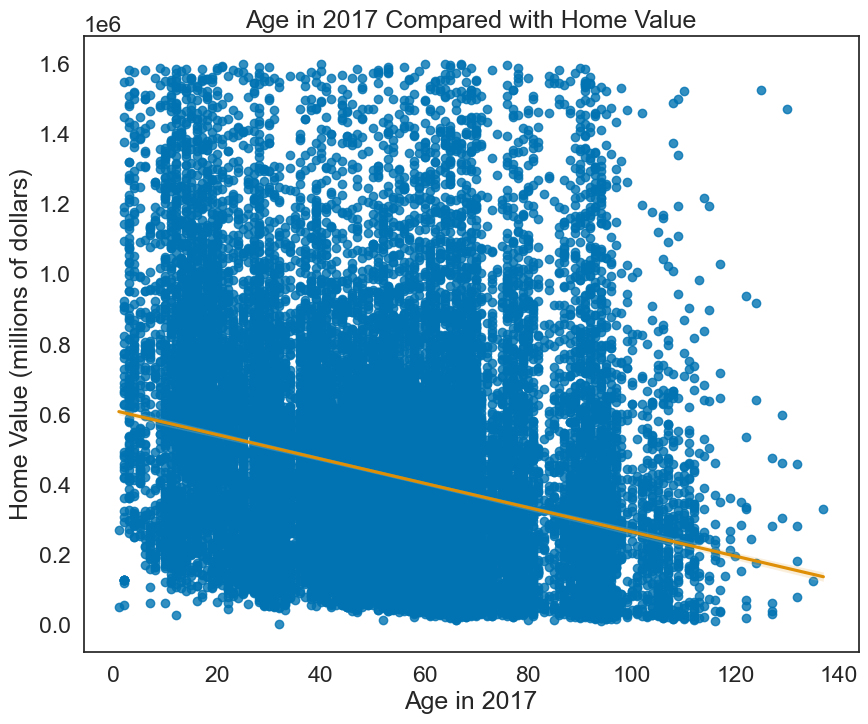

In [8]:
# age compared with home value
e.age_viz(train)

**It looks like there is a difference in home values based on age**

**Set Hypothesis**

**H$_0$** = There is no significant linear correlation between age and home value.

**H$_a$** = There is significant linear correlation between age and home value.

In [9]:
# spearmanr test and results
e.age_spearmanr(train)

Correlation Coefficient: -0.26876814
p-value: 0.0


**Since p < alpha, we can reject the null hypothesis and say there is probably a linear correlation between a home's age and home value**

### *Is there a significant relationship between square footage and home value?*

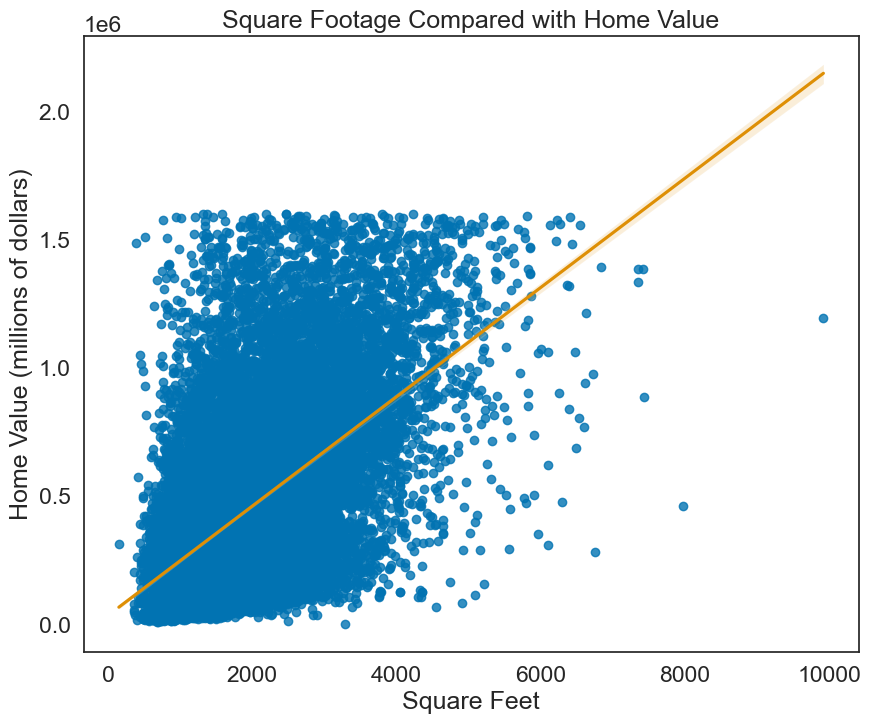

In [10]:
# comparison of square feet with home value
e.square_feet_viz(train)

**It looks like there is a difference in home value by square footage**

**Set Hypothesis**

**H$_0$** = There is no linear correlation between square feet and home value

**H$_a$** = There is a linear correlation between square feet and home value

In [11]:
# spearman test and results
e.sq_feet_spearmanr(train)

Correlation Coefficient: 0.48
p-value: 0.0


**Since p < alpha, we can reject the null hypothesis and say there is probably a linear correlation between square feet and home value**

### *Is there a significant relationship between the bath-to-bed ratio and home value?*

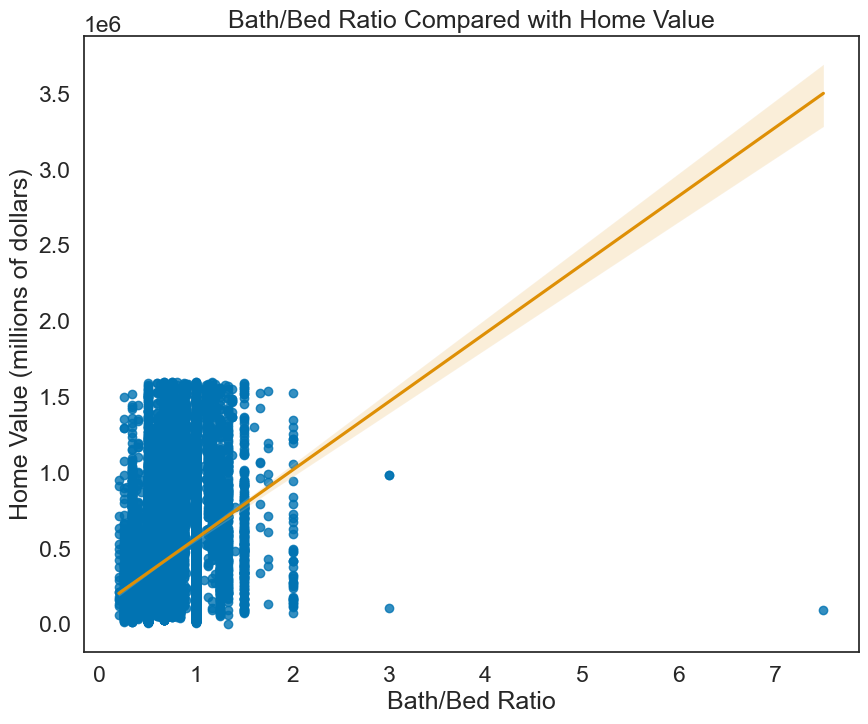

In [12]:
# comparison of bath/bed ratio and home value
e.bath_bed_viz(train)

It looks like there is a linear correlation between bedrooms, bathrooms and home value

**Set Hypothesis**

**H$_0$** = There is no linear correlation between bed_bath_ratio and home value

**H$_a$** = There is a linear correlation between bed_bath_ratio and home value

In [13]:
# spearman test and results
e.bath_bed_ratio_spearmanr(train)

Correlation Coefficient: 0.32
p-value: 0.0


Since p < alpha, we can reject the null hypothesis and say there is probably a linear correlation between bath_bed_ratio and home value.

### Exploration Summary

- square_feet has the highest correlation coefficient.
- bed_bath_ratio, 2017_age, and county all show a relationship with home value.

### Features Moving Forward


- **square_feet**: the correlation coefficient is 0.48 between square_feet and home_value
- **bath_bed_ratio**: the correlation coefficient is 0.32 between bath_bed_ratio and home_value
- **2017_age**: the correlation coefficient is 0.27 between 2017_age and home_value
- **county**: there is a difference between the home values in each county

In [14]:
# list of drivers for modeling
drivers = ['square_feet', 'bath_bed_ratio', '2017_age', 'county']

## Modeling 

### Prep for modeling

- Identified drivers were scaled using MinMax scaler
- Split the data with home_value as the target variable

In [15]:
# prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'home_value', drivers)

### Baseline models

- Reviewed both mean and median for baseline.
- Mean baseline performed better.

In [17]:
#run baseline models mean and median
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,313878.807820,312799.264162,1079.543658
1,median_baseline,320546.288486,319026.131853,1520.156633


### Comparison of Model Performance

In [18]:
# runs various regression models and shows results
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,OLS Regressor,258979.286048,0.319221,255023.466108,0.335266
1,Lasso_alpha_1,258979.859230,0.319218,255020.856580,0.335280
2,GLM,266071.038415,0.281426,264905.697304,0.282763
3,Quadratic,252612.889245,0.352280,248837.702497,0.367125


### Model Performance Takeaways

- All models perfomed better than baseline for both train and validate data.

### **Best model: Random Forest Model**

- The quadratic model (linear regression with polynomial features) performed better than the other models, and the difference between them was a little over 1%
- The quadratic model outperforms the baseline, and there is little variance in accuracy between all three sets of data

In [20]:
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate,RMSE_test,r^2_test
0,Quadratic,252612.889245,0.35228,248837.702497,0.367125,251598.282976,0.353342


## Conclusion

### Summary

- **square_feet** appears to be a driver of home value
- **bath_bed_ratio** appears to be a driver of home value
- **county** appears to be a driver of home value
- **2017_age** appears to be a driver of home value

### Recommendations

- Run this model against other fips clusters to evaluate it's performance in states and cities other than California


### Next Steps

- If new trends are discovered between features while evaluating the model's performance in other fips clusters, engineer new ones and rerun them with the Orange-Ventura-LA county data for any possible relationship with home value.